# ANEOS IRON MODEL: STRENGTH PARAMETERS NOTEBOOK

## ANEOS IRON<br>RELEASE VERSION: SLVTv0.2G1 <br>RELEASE DATE: 20200529

This Jupyter notebook provides documentation for a revised equation of state model for pure iron using the ANEOS code package.

<b>Citation Information</b>

I recommend the following citations with the use of this model:
<ul>
    <li>For the original ANEOS package development and documentation: Thompson & Lauson (1972) and Thompson (1990)
    <li>For the thermal model adjustment capability in ANEOS: Stewart, S., et al. (in press) The Shock Physics of Giant Impacts: Key Requirements for the Equations of State. In J. Lane, T. Germann, and M. Armstrong (Eds.), 21st Biennial APS Conference on Shock Compression of Condensed Matter (SCCM19), AIP Publishing. (arXiv:1910.04687)
    <li>For the development of the iron and iron-alloy equations of state: Stewart, S. T., The Thermodynamics of Giant Impacts:  Results using Improved Equation of State Models, J. Geophysics Research: Planets, in prep.
    <li>For the version-controlled EOS parameters and tables released via https://github.com/ststewart/aneos-iron-2020/: Stewart, S. T., Equation of State Model Iron-ANEOS-SLVTv0.2G1: Documentation and Comparisons (Release 1.0), Zenodo doi:TBD.
    <li>For the version-controlled ANEOS source code: Melosh, Thompson, Collins, Stewart, M-ANEOS v1.0, Zenodo, doi:10.5281/zenodo.3525030. (https://github.com/isale-code/M-ANEOS)
    <li>This EOS for pure iron does not make use of the molecular gas capability of Melosh (2007) or the melt curve+high-pressure phase capability of Collins & Melosh (2014), but the ANEOS code version includes these features.
</ul>

The README file in the github repository provides the history of release versions and associated doi numbers. Future updates to this iron EOS will be version-controlled via GitHub releases with Zenodo doi numbers.

This notebook also highlights several technical issues that arise in developing and implementing EOS models into hydrocodes. We introduce two tabulated quality parameters to help guide usage of this EOS model.<p>

Sarah T. Stewart<br>
sts@ucdavis.edu<br>
Version SLVTv0.2G1SLVTv0.2G1 frozen on 11/5/2019<br>
Documentation updated May 29, 2020<br>
April 12, 2023: added strength notebook<br>

<b>VERSION INFORMATION</b><br>
Iron EOS Version: Iron-ANEOS-SLVTv0.2G1<br>
SLVT# translates to solid-liquid-vapor-thermal model adjustment-version number<br>
G1 = the gridded EOS tables used the gridflag=1 definition for the grid points<br>
SLVTv0.2G1 Public Release Date: May 29, 2020<br>
GitHub: https://github.com/ststewart/aneos-iron-2020/<p>


In [2]:
from datetime import datetime
presentime = datetime.now()
print("Current date and time:", presentime)

# Record the verions information for these calculation for posterity
import platform
print('python version (orig 3.9.12): ',platform.python_version())
del platform
import matplotlib
print('matplotlib version (orig 3.5.1): ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version (orig 1.21.5): ', numpy.__version__)
del numpy
import scipy
print('scipy version (orig 1.7.3): ', scipy.__version__)
del scipy
import pandas
print('pandas version (orig 1.4.2): ', pandas.__version__)
del pandas

# this prevents some error messages for inline plotting in a jupyter notebook
%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
from scipy import interpolate
import colormaps as local_cmaps
import subprocess
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["patch.force_edgecolor"] = True
#
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='None', ecolor='k')

    return artists


# define index function (must be a more efficient way to do this...)
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
#
# LOAD EXTERNAL FUNCTIONS AND OBJECT CLASSES
# defines rational function interpolation functions rf1d and rf2d
#%run rfinterpolation.py 
# defines class objects for extEOStable and functions to read in ANEOS input and output
# READ THIS CODE IF YOU WANT TO UNDERSTAND THE FILE STRUCTURES
%run eostable.py 
# Run the following help for the functions in the class
#help(extEOStable())


from scipy.optimize import curve_fit


Current date and time: 2023-04-12 21:01:02.988001
python version (orig 3.9.12):  3.9.16
matplotlib version (orig 3.5.1):  3.7.0
numpy version (orig 1.21.5):  1.24.2
scipy version (orig 1.7.3):  1.10.0
pandas version (orig 1.4.2):  1.4.2


In [3]:
# -------------------------------------------------------------
# USER INPUTS
#-------------------------------------------------------------
# NOTEBOOK MODE
#-------------------------------------------------------------
#
DEVMODE = 0 # 1=development mode; 0=release mode
#
#-------------------------------------------------------------
# OPTIONS TO REMOVE TENSION REGION AND CONSTRUCT A GADGET2 TABLE
#-------------------------------------------------------------
#
REMOVETENSIONFLAG=1  # 0- keep tension region; 1- remove tension region
MAKEGADGETTABLE=1  # 1=make table; 0=do not make gadget2 table
#
#-------------------------------------------------------------
# USER MUST SET THESE VALUES TO DEFINE THE TABULATED EOS GRIDS
#-------------------------------------------------------------
#
# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Iron-ANEOS-SLVTv0.2G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 191105.     # Date as a single 6-digit number YYMMDD
VERSION = 0.2      # ANEOS Parameters Version number
FMN = 26.          # Formula weight in atomic numbers for Fe
FMW = 55.847       # Formula molecular weight (g/cm3) for Fe
# The following define the default initial state for material in the 201 table
R0REF   = 8.06     # g/cm3 *** R0REF is inserted into the density array; using gamma-iron for rho0
K0REF   = 1.51E12  # dynes/cm2; using gamma-iron for rho0
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#

## Load ANEOS model

Model table files should already be generated with the aneos-pyrolite.ipynb notebook


In [5]:
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname='ANEOS.INPUT',aneosoutfname='ANEOS.OUTPUT')
#
# calculate the principal Hugoniot from the table
if DEVMODE:
    # calculate the Hugoniot and write to a file. This is from the ANEOS REFERENCE STATE
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,writefilename='NEW-SESAME-HUG.TXT')
    # calculate the Hugoniot and write to a file pyrolitic Glass initial state, which is not on this EOS surface (proxy crystalline solid + liquid + vapor)
    # this result is basically the same as the requested Hugoniot at r0 and t0, where ANEOS interprets the initial density to be in tension. Differences at very low pressures.
    #NewEOS.calcOffEOSHugoniot(r0=2.94,t0=298.,p0=1.e-4,e0=0.,r1=3.35,writefilename='NEW-SESAME-HUG-GLASS.TXT')
else:
    # just calculate the Hugoniot and put it in the EOS object
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)
    #NewEOS.calcOffEOSHugoniot(r0=2.94,t0=298.,p0=1.e-4,e0=0.,r1=3.35)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])
    #print(iit,NewEOS.onebar.rho[iit],NewEOS.onebar.T[iit],NewEOS.onebar.S[iit]*1.E3)


Done loading ANEOS files.
ANEOS WAS CALLED WITH THE FOLLOWING INPUT, LOADED FROM FILE  ANEOS.INPUT
 *ANEOS INPUT FILE FOR STSM JUPYTER NOTEBOOK. VARIABLES MUST BE SPACED BY 10 CHARACTERS.
 *         EOS#      string for EOS name           .....Hugoniot initial........ long
 *                                                 T(eV)           Rho(g/cc)     flag
 ANEOS1    -1        'IRON-ANEOS-SLVTv0.2'         THUG=0.02568    RHUG=7.874    LONG

 *
 *         nelem     type      rho0      temp0(K)  press0    B0/-Cbulk Gamma0    Tdebye(K)
 *         V01       V02       V03       V04       V05       V06       V07       V08
 ANEOS2    1         4         8.06      298.      1.e6      1.51E12   1.90      -450.0 

 *         or S1     3*C24     erg/g     or -Em    C53       C54       H0        C41
 *         V09       V10       V11       V12       V13       V14       V15       V16
 * Esep adjusted to match 1-bar boiling pt with cv=1.33*3nR
 ANEOS3    0.        1.5       10.20E10  1809.     0. 

## Load literature data

## Melt curve Simon-Glatzel fit



LINEAR FITS ARE POOR FOR U(P):
solidus fit U(P GPa) MJ/kg =  [0.01759291 1.03393134]
liquidus fit U(P GPa) MJ/kg =  [0.0177442  1.24228498]
Simon-Glatzel fit is better U(P):
liquidus
Actual Ul at P=0 is  1.313999999999887  Using 1.314 MJ/kg
Simons fit parameters to liquidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)=  1.314 71.52818101531236 1.0173480576317764
solidus
Actual Us at P=0 is  1.0669999999985949  Using 1.067 MJ/kg
Simons fit parameters to solidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)=  1.067 56.75801234087112 1.0267406394503784
Simon-Glatzel equation to melt curve T(P):
Actual T at P=0 is  1808.9999999902632  Using 1809 K.
Simons fit parameters (tref (K), a (GPa), c [-]; pref=0)=  1809 10.418193749068042 3.0632503405922877


/var/folders/rd/f2t78k5x6jxd8lf_w1wmvnc40000gn/T/ipykernel_13165/1192223693.py:182: RuntimeWarning: invalid value encountered in power
  return 1809*np.power( (p/a + 1),(1/c) )


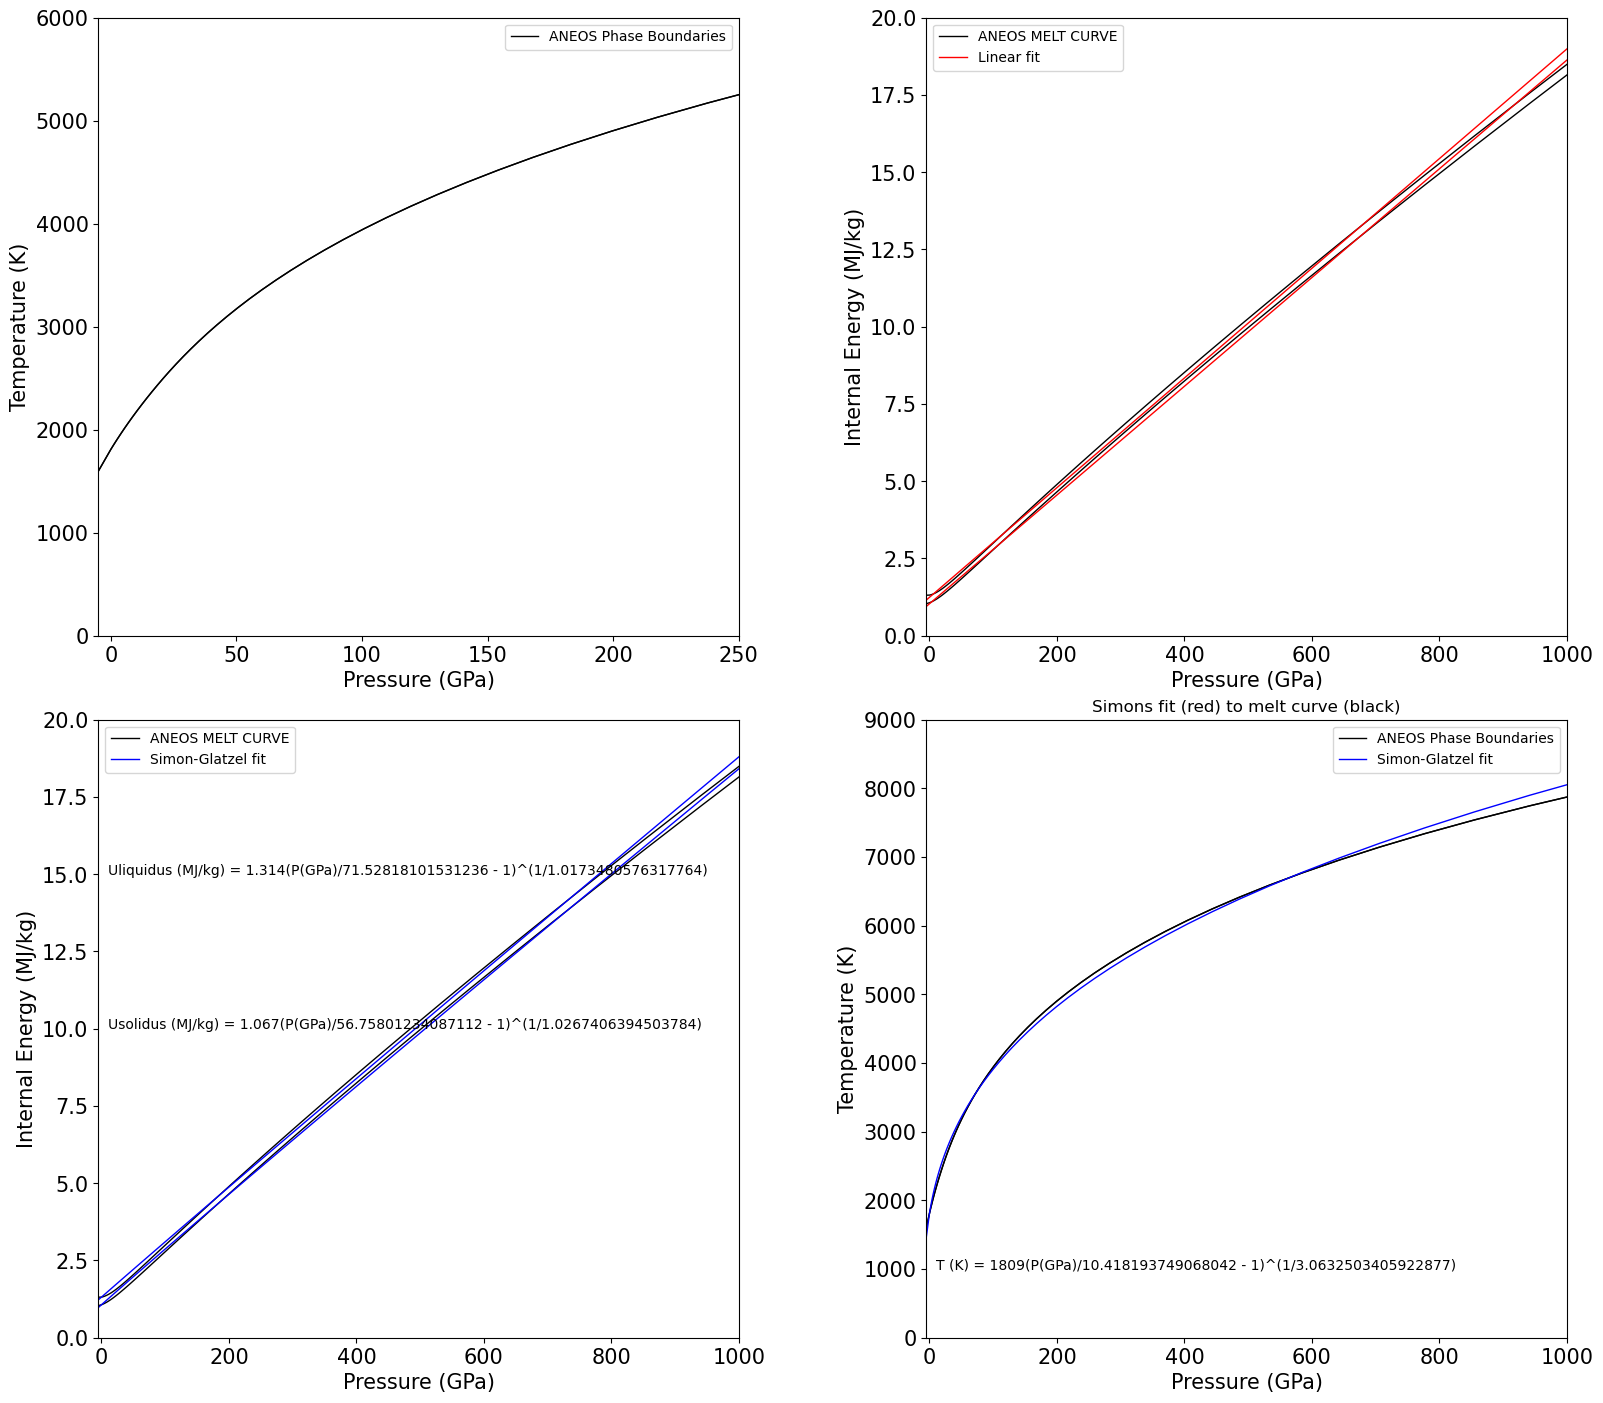

In [10]:
#========== PLOTTING STYLES FOR LOTS OF PLOTS =================

styleanhug = ['-','red',1,'ANEOS THUG,RHUG Hugoniot (liquid MORB)'] 
stylestphug = ['-','blue',1,'Tabulated STP Hugoniot']
styleanphase = ['-','black',1,'ANEOS Phase Boundaries']
stylephasept = ['o','black',6]


# PHASE DIAGRAM PLOTS
#======================LOTS OF PLOTS============================
# Plot aneos phase boundaries with focus on the vapor curve
sfont = 15
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,14))
plt.subplots_adjust(wspace=0.4)

#------------------------------



#-------
# temperature - pressure
ai=0
aj=0
if NewEOS.tp.T > 0:
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.T[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,6000)
axes[ai,aj].set_xlim(-5,250)

#-------
# energy - pressure
ai=0
aj=1
if NewEOS.tp.T > 0:
#    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label='ANEOS MELT CURVE')
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.Us,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.U,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.U[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Internal Energy (MJ/kg)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,20)
axes[ai,aj].set_xlim(-5,1000)

print('LINEAR FITS ARE POOR FOR U(P):')
# linear fit to solidus and liquidus between 0 to 1000 GPa
zzz = np.where((NewEOS.mc.Pl > 0.) & (NewEOS.mc.Pl < 1000))[0]

res = np.polyfit(NewEOS.mc.Ps[zzz],NewEOS.mc.Us[zzz],1)
print('solidus fit U(P GPa) MJ/kg = ',res)
axes[ai,aj].plot(NewEOS.mc.Ps,res[1]+res[0]*NewEOS.mc.Ps,styleanphase[0],color='red',linewidth=styleanphase[2],label='Linear fit')

res = np.polyfit(NewEOS.mc.Pl[zzz],NewEOS.mc.Ul[zzz],1)
print('liquidus fit U(P GPa) MJ/kg = ',res)
axes[ai,aj].plot(NewEOS.mc.Pl,res[1]+res[0]*NewEOS.mc.Pl,styleanphase[0],color='red',linewidth=styleanphase[2])

#-------
# energy - pressure
ai=1
aj=0
if NewEOS.tp.T > 0:
#    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label='ANEOS MELT CURVE')
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.Us,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.U,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.U[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Internal Energy (MJ/kg)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,20)
axes[ai,aj].set_xlim(-5,1000)

# Simon-Glatzel fit is better
print('Simon-Glatzel fit is better U(P):')
print('liquidus')
eref = np.interp(0,NewEOS.mc.Pl,NewEOS.mc.Ul)
print('Actual Ul at P=0 is ',eref,' Using 1.314 MJ/kg')
eref =  1.314
def simonsE_func(p, a, c):
    return 1.314*np.power( (p/a + 1),(1/c) )
# only positive numbers and in a reasonable pressure range for this EOS
zzz = np.where((NewEOS.mc.Pl > 0.) & (NewEOS.mc.Pl < 1000))[0]
popt, pcov = curve_fit(simonsE_func, NewEOS.mc.Pl[zzz], NewEOS.mc.Ul[zzz])
# popt contains the optimized values of a and c
a, c = popt
print('Simons fit parameters to liquidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)= ',eref, a,c)
# plot the Simon's fit
axes[ai,aj].plot(NewEOS.mc.Pl,simonsE_func(NewEOS.mc.Pl, a, c),styleanphase[0],color='blue',linewidth=styleanphase[2],label='Simon-Glatzel fit')
axes[ai,aj].text(10,15,'Uliquidus (MJ/kg) = '+str(eref)+'(P(GPa)/'+str(a)+' - 1)^(1/'+str(c)+')')

print('solidus')
eref = np.interp(0,NewEOS.mc.Ps,NewEOS.mc.Us)
print('Actual Us at P=0 is ',eref,' Using 1.067 MJ/kg')
eref = 1.067
def simonsE_func(p, a, c):
    return 1.067*np.power( (p/a + 1),(1/c) )
# only positive numbers and in a reasonable pressure range for this EOS
zzz = np.where((NewEOS.mc.Ps > 0.) & (NewEOS.mc.Ps < 1000))[0]
popt, pcov = curve_fit(simonsE_func, NewEOS.mc.Ps[zzz], NewEOS.mc.Us[zzz])
# popt contains the optimized values of a and c
a, c = popt
print('Simons fit parameters to solidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)= ',eref, a,c)
# plot the Simon's fit
axes[ai,aj].plot(NewEOS.mc.Ps,simonsE_func(NewEOS.mc.Ps, a, c),styleanphase[0],color='blue',linewidth=styleanphase[2])
axes[ai,aj].text(10,10,'Usolidus (MJ/kg) = '+str(eref)+'(P(GPa)/'+str(a)+' - 1)^(1/'+str(c)+')')

#-------
# pressure - temperature melt curve
ai=1
aj=1
#axes[ai,aj].plot(NewEOS.vc.Pl,NewEOS.vc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
#axes[ai,aj].plot(NewEOS.vc.Pv,NewEOS.vc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])
#axes[ai,aj].plot(NewEOS.cp.P,NewEOS.cp.T,'o',color=stylephasept[1],markersize=stylephasept[2])
if NewEOS.tp.T > 0:
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.T[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,9000)
axes[ai,aj].set_xlim(-5,1000)
axes[ai,aj].set_title('Simons fit (red) to melt curve (black)')

print('Simon-Glatzel equation to melt curve T(P):')
# fit Simon-Glatzel equation to melt curve
# CTH implementation is Tref is at Pref = zero
# mt=Tm∗ (P( I ) / simona+PONE) ∗ ∗ (PONE/ simonc )
# Simon-Glatzel equation
# Tm = Tref * [(P-Pref)/a+1]^(1/c)

tref = np.interp(0,NewEOS.mc.Pl,NewEOS.mc.T)
print('Actual T at P=0 is ',tref,' Using 1809 K.')
tref = 1809
# initial guesses
a = 1.84 # GPa
c = 7.27 # dimless
def simons_func(p, a, c):
    return 1809*np.power( (p/a + 1),(1/c) )
# only positive numbers and in a reasonable pressure range for this EOS
zzz = np.where((NewEOS.mc.Pl > 0.) & (NewEOS.mc.Pl < 1000))[0]
popt, pcov = curve_fit(simons_func, NewEOS.mc.Pl[zzz], NewEOS.mc.T[zzz])
# popt contains the optimized values of a and c
a, c = popt
print('Simons fit parameters (tref (K), a (GPa), c [-]; pref=0)= ',tref, a,c)
# plot the Simon's fit
axes[ai,aj].plot(NewEOS.mc.Ps,simons_func(NewEOS.mc.Ps, a, c),styleanphase[0],color='blue',linewidth=styleanphase[2],label='Simon-Glatzel fit')
axes[ai,aj].text(10,1000,'T (K) = '+str(tref)+'(P(GPa)/'+str(a)+' - 1)^(1/'+str(c)+')')



    

# don't show a plot in lower right
#axes[3,1].axis("off")

axes[0,0].legend(fontsize=sfont-5)
axes[0,1].legend(fontsize=sfont-5)
axes[1,0].legend(fontsize=sfont-5)
axes[1,1].legend(fontsize=sfont-5)




plt.tight_layout(pad=0.6)
plt.savefig(MODELNAME+'-melt-curve-fits.pdf', format='pdf', dpi=1000,transparent=True)
#--------



## Melt curve was fit from 0 to 1000 GPa
\begin{equation}
    F=A\left(\frac{P}{a}+1\right)^{\frac{1}{c}}
\end{equation}

| Variable | T(P)   | Solidus U(P) | Liquidus U(P) |
|----------|--------|--------------|---------------|
| Units    | K, GPa | MJ/kg, GPa   | MJ/kg, GPa     |
|   A      | 1809   | 1.067        | 1.314  |
|   a      | 10.418 | 56.758       | 71.528 |
|   c      | 3.0633 | 1.0267       | 1.0173 |


The covariance matrices are in the code cells above.

Double check these numbers match the expressions on the plot!


end of notebook